# energy-based symbolic regression for math

use symbolic regression with energy instead of data to find equations that match certain requirements, eg has asymptote at x, evaluates to 3, etc. this is in comparison to typical symbolic regression, which fits parametric eq to data. no data here. unless you make custom loss function that evaluates residuals to data or something.

based on hopfield network. char index & output position form unique index along u & V. As such, len(connectivity matrix) is numchars\*len(output)\*numchars\*len(output).

search requirements are created by either adding additional Q functs (functions that modify Q, mostly used for ensuring math syntax), or by adding extensions to loss function. for example, create an energy function which evaluates the output, and increases loss by mse based on the value that is searched for (like, return 0 loss if we are searching for eval to 3 and model returns 2+1)

currently only basic operators are implemented (+-*/).

serves as proof of concept of energy-based symbolic regression for use in parametric equation searching. to be adapted to generate code.


todo:
- finish loss function extensionality, completing proof that this does in fact symbolically regress /check
- make QFactory more generic (not just pos, char, but able to support ndimensional indexing) (i dont think it needs this within the scope of symbolic regression?)
- enable 3rd order connections, eg Q*Q (useful for inhibiting cases like '/x<operator>', which may result in dividing by zero)
- if sticking with math: create qfuncts for latex grammar (can now search using latex output)
- if moving to programming langauge output: create qfunc base for a programming language output
-- what the heck does a loss extension funct for this look like? just run eval() on generated code and see if it works? lol


## imports

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import re
import math
from typing import Callable, List, Dict, Union, Tuple

#testing vars
global c_iter
global eval_clip_to


## OneHotEncoder, QFactory, IFactory

In [89]:
class OneHotEncoder:
    def __init__(self, chars):
        self.chars = chars
        self.num_syms = len(chars)

    def encode(self, s):
        encoded = np.zeros((len(s), self.num_syms))
        for i, c in enumerate(s):
            encoded[i, self.chars.index(c)] = 1
        return encoded

    def decode(self, encoded):
        decoded = ""
        for row in encoded:
            idx = np.argmax(row)
            decoded += self.chars[idx]
        return decoded

class QFactory:
    def __init__(self, max_str_len: int, chars: List[str], conf: Dict[str, float]=None, sets: Dict[str, List[str]]=None):
        self.max_str_len = max_str_len
        self.chars = chars
        self.conf = conf
        self.sets = sets

        self.num_syms = len(chars)
        self.nUnits = max_str_len * self.num_syms

        self.Q = np.zeros((self.nUnits, self.nUnits))

    def _get_idx(self, out_position: int, char: str):
        return self.num_syms * out_position + self.chars.index(char)

    def qget(self, out_position: int = None, char: str = None, out_position2: int = None, char2: str = None):
        if out_position is not None and char is not None:
            idx1 = self._get_idx(out_position, char)
            idx2 = idx1 if out_position2 is None or char2 is None else self._get_idx(out_position2, char2)

            return self.Q[idx1, idx2]
        elif char is None:
            return np.take[self.Q, [self._get_idx(out_position, c) for c in self.chars]]#self.Q[self.num_syms*out_position:(self.num_syms+1)*out_position,:]
        elif out_position is None:
            return np.take[self.Q, [self._get_idx(o, char) for o in range(self.max_str_len)]]
        else:
            return self.Q

    def qset(self, out_position: int, char: str, v: float, out_position2: int = None, char2: str = None, r: bool = True):
        idx1 = self._get_idx(out_position, char)

        # if out_position2 and char2 aren't specified, default to setting the self-connection
        idx2 = idx1 if out_position2 is None or char2 is None else self._get_idx(out_position2, char2)

        self.Q[idx1, idx2] = v

        if r:
           self.Q[idx2, idx1] = v

    def qadj(self, out_position: int, char: str, v: float, out_position2: int = None, char2: str = None, r: bool = True):
        idx1 = self._get_idx(out_position, char)
        idx2 = idx1 if out_position2 is None or char2 is None else self._get_idx(out_position2, char2)
        self.Q[idx1, idx2] += v

        if r and (out_position2 is not None) and (char2 is not None):
           self.Q[idx2, idx1] += v

    def averages(self, mean: str = None):
        avg_values = np.zeros((self.num_syms, self.max_str_len))

        for self_pos in range(self.max_str_len):
            for self_char in self.chars:
                self_char_idx = self.chars.index(self_char)

                #print(f'c: {self_pos},{self_char} ({self._get_idx(self_pos, self_char)})')

                sum_inhibition = 0
                for effector_pos in range(self.max_str_len):
                    for effector_char in self.chars:
                        sum_inhibition += self.qget(effector_pos, effector_char, self_pos, self_char)
                avg_values[self_char_idx, self_pos] = sum_inhibition/(self.max_str_len*self.num_syms)

        #average inhibition on characters, despite pos
        if mean=="char":
            return np.mean(avg_values,1)

        #average inhibition on pos, despite character
        elif mean=="pos":
            return np.mean(avg_values,0)

        return avg_values

    def plot(self):
        plt.imshow(self.Q)
        plt.show()

class IFactory:
    def __init__(self, max_str_len: int, chars: List[str], conf: Dict[str, float] = None, sets: Dict[str, List[str]] = None):
        self.max_str_len = max_str_len
        self.chars = chars
        self.conf = conf
        self.sets = sets

        self.num_syms = len(chars)
        self.I = np.zeros((self.max_str_len * self.num_syms, 1))#np.random.rand(self.max_str_len * self.num_syms, 1)

    def _get_idx(self, pos: int, char: str):
        return pos * self.num_syms + self.chars.index(char)

    def iadj(self, pos: int, char: str, value: float):
        self.I[self._get_idx(pos, char)] += value

    def iset(self, pos: int, char: str, value: float):
        self.I[self._get_idx(pos, char)] = value

    def iget(self, pos: int, char: str, value: float):
        return self.I[self._get_idx(pos, char)]

    def plot(self):
        plt.imshow(self.I.reshape((self.max_str_len, self.num_syms)))
        plt.show()


## Loss

In [110]:
CleanFunctCallable = Callable[[np.ndarray, str], str]


class EvaluatorBase:
    def forward(self, tokenstring: str) -> Tuple[float, float]:
        # some function on tokenstring, eg eval()
        # return Tuple(y_evaluated, y_true)
        # return None to indicate failure to evaluate
        return None

    def __call__(self, s):
        return self.forward(s)

class LossMetric:
    def __init__(self):
        self.metric_type = None
    def forward(self, y: float, y_o: float) -> float:
        return y - y_o
    def __call__(self, y, y_o):
        return self.forward(y, y_o)

class MSE(LossMetric):
    def __init__(self, scaler=1):
        self.metric_type = "MSE"
        self.scaler = scaler
    def forward(self, y:float, y_o:float) -> float:
        return abs(y - y_o)**2 * self.scaler

class MAE(LossMetric):
    def __init__(self, scaler=1):
        self.metric_type = "MAE"
        self.scaler = scaler
    def forward(self, y:float, y_o:float) -> float:
        return abs(y - y_o) * self.scaler


class EvalLoss:
    def __init__(self, evaluator: 'EvaluatorBase', max_str_len, num_syms, min_E=-100, metric: Union[str,'LossMetric'] = "MAE", eval_clip = 400, eval_fit_curve=1.4):
        self.max_str_len = max_str_len
        self.num_syms = num_syms
        self.nUnits = self.max_str_len*self.num_syms
        self.evaluator = evaluator
        self.min_E = min_E
        self.metric = metric
        self.eval_clip = eval_clip
        self.eval_fit_curve = eval_fit_curve

        if type(self.metric) == str:
            if self.metric == "MSE":
                self.metric = MSE()
            elif self.metric == "MAE":
                self.metric = MAE()

        self._pf = lambda s: s


    def set_tokenstring_preprocess_function(self, f: CleanFunctCallable):
        self._pf = f


    @staticmethod
    def squash(l, max_loss=100, max_loss_in=400, curve=1.4):
        # https://www.desmos.com/calculator/se1robxbad

        y = max_loss * (abs(l)**curve) / (max_loss_in**curve)

        #y = max_loss * (l)**2 / max_loss_in**2

        return -1*min(max_loss, y)


    @staticmethod
    def scaled_sigmoid(x, d1=-1, d2=1, r1=-1, r2=1, c=0.125):
        """
        Scaled and shifted sigmoid function based on given parameters.

        x: Input value or array
        d1, d2: Domain range where d1 is the starting point and d2 is the ending point.
        r1, r2: Range where r1 is the starting point and r2 is the ending point.
        c: Curving constant.

        Returns the scaled and shifted sigmoid value.
        """
        sigmoid_value = 1 / (1 + np.exp((-x + (d1 + (d2 - d1) / 2)) / (c * (d2 - d1))))
        return (r2 - r1) * sigmoid_value + r1


    def forward(self, token_string: str, Q: np.ndarray, u: np.ndarray, V: np.ndarray, E: float) -> np.ndarray:


        #---- evaluate V to get eval loss from evaluator

        c_ts = self._pf(V, token_string)

        if E > self.min_E:
            #return 0 if energy is too high (give model time to output evaluable expressions, etc)
            return np.zeros(V.shape)

        ys = self.evaluator(c_ts)
        if ys is None:
            return -1*np.ones(V.shape)*self.eval_clip
        y_o, y_t = ys

        metric_loss_value = -1 * self.metric(ys[0], ys[1])

        #print(f"r: {metric_loss_value}")

        y_s = self.squash(metric_loss_value,max_loss=eval_clip_to, max_loss_in=self.eval_clip, curve=self.eval_fit_curve)

        #print(f"y_s: {y_s}") #y_s: -1


        #----- get most active neurons mask matrix

        V_reshaped = V.reshape(self.max_str_len, self.num_syms)

        row_indices = np.arange(self.max_str_len)
        col_indices = np.argmax(V_reshaped, axis=1)

        most_active_neurons_mask_reshaped = np.zeros_like(V_reshaped)
        most_active_neurons_mask_reshaped[row_indices, col_indices] = 1
        most_active_neurons_mask = most_active_neurons_mask_reshaped.reshape((self.max_str_len * self.num_syms, 1))

        #print("most_active_neurons_mask: ")
        #print(most_active_neurons_mask.reshape((self.max_str_len, self.num_syms)))

        #----- get total influence on each of the most activated neurons, to create a normalizer


        # Get the most activated values in V #in future: if making generalized hopfield ml framework, use (V > 0.5).astype(float) to not be limited by 1 per row
        #most_activated_indices = [l for l in enumerate(np.argmax(V.reshape(self.max_str_len, self.num_syms), axis=1))]

        activated_neurons_influence_sum_matrix = most_active_neurons_mask.copy()
        for pos, char_id in zip(row_indices, col_indices):
            idx = pos * self.num_syms + char_id

            sum_influence = 0

            # Check the influence of other neurons on this neuron using the Q matrix
            for other_neuron in range(Q.shape[0]):
                sum_influence += Q[other_neuron, idx]
                # using np.dot(Q, V[ids]) does not work as we don't want self connections or influence from this neuron to other neurons, only others to this (in case non-mutual connections)

            activated_neurons_influence_sum_matrix[pos * self.num_syms + char_id] *= sum_influence * -1

        max_sum_abs_influence = np.max(np.abs(activated_neurons_influence_sum_matrix[np.where(np.abs(activated_neurons_influence_sum_matrix) > 0)]))


        #print("activated_neurons_influence_sum_matrix: ")
        #print(activated_neurons_influence_sum_matrix.reshape((self.max_str_len, self.num_syms)))


        #----- create spread_neurons_loss_matrix with normalizing scalars such that sum_influence for
        #      each activated_neurons_influence_sum_matrix would be max_sum_abs_influence. this matrix
        #      will hold the amount of influence the neuron at that position has on the most active neurons

        spread_neurons_loss_matrix = np.zeros_like(u)

        #print(f"max_sum_abs_influence: {max_sum_abs_influence}")

        for pos, char_id in zip(row_indices, col_indices):
            idx = pos * self.num_syms + char_id
            scaler = abs(activated_neurons_influence_sum_matrix[pos * self.num_syms + char_id]) / max_sum_abs_influence
            #print(f"pos 1 scaler: {scaler}")
            for other_neuron in range(Q.shape[0]):
                spread_neurons_loss_matrix[other_neuron] += Q[other_neuron, idx] * scaler
                #if abs(Q[other_neuron, idx]) > 0:
                    #print(f"snlm at {(other_neuron//self.num_syms, other_neuron%self.num_syms)} was appended by {Q[other_neuron, idx]} * {scaler} = {Q[other_neuron, idx] * scaler}. is now {spread_neurons_loss_matrix[other_neuron]}")


        #----- set all most activated neurons to be max_sum_abs_influence

        activated_neurons_loss_matrix = most_active_neurons_mask * max_sum_abs_influence

        #print("activated_neurons_loss_matrix")
        #print(activated_neurons_loss_matrix.reshape((self.max_str_len, self.num_syms)))

        #print("spread_neurons_loss_matrix")
        #print(spread_neurons_loss_matrix.reshape((self.max_str_len, self.num_syms)))

        #----- get full loss matrix

        unsquashed_loss_matrix = activated_neurons_loss_matrix + spread_neurons_loss_matrix
        unsquashed_loss_matrix *= -1

        #print("unsquashed loss matrix: ")
        #print(unsquashed_loss_matrix.reshape((self.max_str_len, self.num_syms)))

        loss_matrix_base = self.scaled_sigmoid(unsquashed_loss_matrix, d1=-1*max_sum_abs_influence,d2=max_sum_abs_influence,r1=-1,r2=1)

        #print("squashed loss matrix:")
        #print(loss_matrix_base.reshape((self.max_str_len, self.num_syms)))

        loss_matrix = loss_matrix_base * y_s * -1

        #print("eval_applied loss matrix:")
        #print(loss_matrix.reshape((self.max_str_len, self.num_syms)))



        return loss_matrix


    def __call__(self, token_string: str, Q: np.ndarray, u: np.ndarray, V: np.ndarray, E: float) -> np.ndarray:
        return self.forward(token_string, Q, u, V, E)



## Hopfield Symbolic Regression (H_SymReg)

In [111]:
from traitlets.config import ArgumentError
from typing import Optional, Callable, List, Dict, Tuple, Union
from matplotlib.animation import FuncAnimation

QFunctCallable = Callable[['QFactory', int, List[str]], None]
IFunctCallable = Callable[['IFactory', int, List[str]], None]

class H_SymReg:
    def __init__(self, chars: List[str], max_str_len: int = 10, gain: float = 999, dt: float = 0.01, min_energy_for_eval: float = -100, eval_clip: float = 400,
                 Qfuncts: List[QFunctCallable] = None, Ifuncts: List[IFunctCallable] = None,
                 loss: 'EvalLoss' = None, optimizer: 'Optimizer' = None, evaluator: 'EvaluatorBase' = None,
                 conf: Dict[str, float] = None, sets: Dict[str, List[str]] = None,
                 cleanfunct: CleanFunctCallable = None):

        if not chars:
            raise AttributeError("chars must be defined")

        self.encoder = OneHotEncoder(chars)
        self.chars = chars
        self.max_str_len = max_str_len
        self.num_syms = len(chars)
        self.nUnits = max_str_len * self.num_syms
        self.gain = gain
        self.dt = dt
        self.u = (np.random.rand(self.nUnits, 1) - 0.5) * 0.01 + 0.5
        self.V = self.squasher(self.u, self.gain)
        self.E_hist = [np.inf]
        self.V_hist = [self.V]
        self.u_hist = [self.u]
        self.L_hist = [np.zeros_like(self.V)]


        #I & Q
        self.conf = conf
        self.sets = sets

        self.ifactory = IFactory(self.max_str_len, self.chars, self.conf, self.sets)
        if Ifuncts is None or len(Ifuncts) == 0:
            self.Ifuncts = []
        else:
            self.Ifuncts = Ifuncts
            for ifunc in self.Ifuncts:
                ifunc(self.ifactory, self.max_str_len, self.chars)
        self.I = self.ifactory.I

        self.qfactory = QFactory(self.max_str_len, self.chars, self.conf, self.sets)
        if Qfuncts is None or len(Qfuncts) == 0:
            raise Warning("Qfuncts not defined- do you really want to train on empty connectivity matrix?")
            self.Qfuncts = []
        else:
            self.Qfuncts = Qfuncts
            for qfunc in self.Qfuncts:
                qfunc(self.qfactory, self.max_str_len, self.chars)
        self.Q = self.qfactory.Q


        #losses & optimizer
        if evaluator is None:
            raise AttributeError("Evaluator is not set.")
        self.evaluator = evaluator

        if cleanfunct is None:
            cleanfunct = lambda s: s
        self.clean_output = cleanfunct

        if loss is None:
            self.get_loss = EvalLoss(self.evaluator, self.max_str_len, self.num_syms, eval_clip=eval_clip, min_E=min_energy_for_eval)
        else:
            self.get_loss = loss
        self.get_loss.set_tokenstring_preprocess_function(self.clean_output)


        self.optimizer = optimizer
        if optimizer is not None:
            self.optimizer.set_model(self)


    @staticmethod
    def squasher(u, gain):
        return 0.5 * (1 + np.tanh((u - 0.5) * gain))

    def get_evalloss(self, eq: str = None, Q: np.ndarray = None, u: np.ndarray = None, V: np.ndarray = None, E: float = None):
        if Q is None: Q = self.Q
        if u is None: u = self.u
        if V is None: V = self.V
        if eq is None: eq = self.decode_output(V=V, clean=True)
        if E is None: E = self.E_hist[-1]

        return self.get_loss.forward(eq, Q, u, V, E)


    def evaluate(self, eq: Union[str, np.ndarray]):
        if type(eq) == str:
            pass
        elif type(eq) == np.ndarray:
          eq = self.decode_output(V=eq)

        else:
            raise ArgumentError("Invalid arguement type in position 2")

        ys = self.evaluator(eq)
        if ys is None:
            return None
        else:
            return ys[0]


    def update(self, I=None, n_iters=1000, min_dE=0.0001, earlystopping=50, min_E=-130):
        """
        I = bias
        n_iters = epochs
        min_dl = minimum change in L before noticing change in L
        earlystopping = number of iters without change before quitting
        min_L = minimum energy before quitting
        """
        if I is None:
            I = self.I

        min_found_E = np.inf
        lastBigJump = 0


        for e in range(n_iters):

            global c_iter
            c_iter = e

            # evallosses
            L = self.get_evalloss(eq = self.decode_output(V=self.V, clean=True))

            if self.optimizer is not None:
                L = self.optimizer.process(L, self. V)


            new_I = L#/self.dt# + I

            self.L_hist.append(new_I)


            du = -self.u + self.Q @ self.V + new_I
            self.u += du * self.dt# + L# + new_I
            self.V = self.squasher(self.u, self.gain)

            # energy calc
            E = (-0.5 * np.dot(self.V.T, np.dot(self.Q, self.V)) - np.dot(self.V.T, new_I))[0][0]
            #print(f"{i},{np.dot(self.V.T, new_I)}")

            self.E_hist.append(E)
            self.u_hist.append(self.u.copy())
            self.V_hist.append(self.V)

            if len(self.E_hist) > 1:
                dE = self.E_hist[-1] - self.E_hist[-2]

                if np.abs(dE) < min_dE:
                    lastBigJump = e
                min_found_E = min(min_found_E, E)


                #print(f"{(np.abs(dL) <= min_dL)}, {(L < minL)}, {(i - lastBigJump) >= 100}")
                #if ((np.abs(dL) <= min_dL) and (L < minL)) or ((i - lastBigJump) >= 100):
                #    break
                if (e - lastBigJump) >= earlystopping:
                    break
                if min_E is not None and E < min_E:
                    break

                if e%(n_iters//100)==0:
                    print(f'{e}: {self.decode_output(self.V, clean=False)}')

    def plot_results(self):
        V_reshaped = self.V.reshape(self.max_str_len, self.num_syms)
        plt.imshow(V_reshaped)
        plt.show()


    def plot_Ehist(self, max_y=None):
        #plt.set_xlim((1,len(self.L_hist)))
        plt.plot(np.arange(1, len(self.E_hist)), self.E_hist[1:])
        if max_y is not None:
            plt.ylim((np.min(self.E_hist[1:])-5, min(np.max(self.E_hist[1:])+5,max_y)))#np.max(self.E_hist[1:])+5))

        plt.show()


    def plot_histories_as_video(self):

        fig, axes = plt.subplots(2, 2, figsize=(8, 6))

        axes[0, 0].set_title('V')
        axes[0, 1].set_title('u')
        axes[1, 0].set_title('Energy')
        axes[1, 1].set_title('Eval Loss')

        # Reshape grid datas
        c_V_hist = [v.reshape(self.max_str_len, self.num_syms) for v in self.V_hist]
        c_u_hist = [u.reshape(self.max_str_len, self.num_syms) for u in self.u_hist]
        c_L_hist = [l.reshape((self.max_str_len, self.num_syms)) for l in self.L_hist]

        # Get global min and max for consistent color limits
        global_min_V = min(matrix.min() for matrix in c_V_hist)
        global_max_V = max(matrix.max() for matrix in c_V_hist)
        global_min_u = min(matrix.min() for matrix in c_u_hist)
        global_max_u = max(matrix.max() for matrix in c_u_hist)
        global_min_L = min(matrix.min() for matrix in c_L_hist)
        global_max_L = max(matrix.max() for matrix in c_L_hist)

        im_V = axes[0, 0].imshow(c_V_hist[0], cmap='viridis', vmin=global_min_V, vmax=global_max_V)
        im_u = axes[0, 1].imshow(c_u_hist[0], cmap='viridis', vmin=global_min_u, vmax=global_max_u)
        line, = axes[1, 0].plot([], [])
        im_L = axes[1, 1].imshow(c_L_hist[0], cmap='viridis', vmin=global_min_L, vmax=global_max_L)

        #fig.colorbar(im_V, ax=axes[0, 0])
        fig.colorbar(im_u, ax=axes[0, 1])
        fig.colorbar(im_L, ax=axes[1, 1])

        def animate(i):
            s = self.decode_output(V=c_V_hist[i].reshape((self.nUnits,1)))
            y = self.evaluate(s)
            if y is not None:
                s += f" = {y}"
            fig.suptitle(f"{s}")
            im_V.set_array(c_V_hist[i])
            im_u.set_array(c_u_hist[i])
            im_L.set_array(c_L_hist[i])
            if i >= 1:
                line.set_data(np.arange(1, i + 1), self.E_hist[1:i + 1])
                axes[1, 0].relim()
                axes[1, 0].autoscale_view(True, True, True)


        anim = FuncAnimation(fig, animate, frames=len(c_V_hist), interval=40, repeat=False)

        from IPython.display import HTML
        return HTML(anim.to_html5_video())


    def decode_output(self, V: np.ndarray = None, clean: bool = True):
        if V is None:
            V = self.V
        reshaped_V = V.reshape(self.max_str_len, self.num_syms)
        o =  self.encoder.decode(reshaped_V)

        if clean:
            o = self.clean_output(V=V, expr=o)

        return o


## Implementation for Math Function Searching

### Cleaning Function

In [92]:
def cleanfunct(V: np.ndarray = None, expr: str = None) -> str:

    if expr is not None:
        # Replace sequences of zeros with a single zero
        expr = re.sub(r'(^0+|(?<=[+\-/*])0+)(?=$|[+\-/*x1-9])', '0', expr)

        # Remove unnecessary leading zeros from numbers
        expr = re.sub(r'^|(?<=[+\-/*])(0+)(?=[1-9])', '', expr)

        # Remove empty char
        expr = expr.replace('N','')

        return expr

    return None

### QFuncts

In [93]:
## char-position rules
def only_one_char_for_each_position(qf: 'QFactory', max_str_len: int, chars: List[str]) -> None:
    #inhibit results from within the same position
    for pos in range(max_str_len):
        for char in chars:
            for char2 in chars:
                if char != char2:
                    qf.qset(pos, char, qf.conf['c'], pos, char2)



## operators
def operator_adjs(qf: 'QFactory', max_str_len: int, chars: List[str]) -> None:
    # Additional rules for operators: penalize if an operator follows another operator (or empty char), penalize if it's the first or last position
    for pos in range(max_str_len):
        for char in qf.sets["operators"] + ['N']:
            if pos < max_str_len - 1:
                for next_char in qf.sets["operators"]:
                    qf.qset(pos, char, qf.conf["ofo"], pos + 1, next_char)
            if char != "N" and (pos == 0 or pos == max_str_len - 1):
                qf.qset(pos, char, qf.conf["ose"])



## ints
def consec_ints(qf: 'QFactory', max_str_len: int, chars: List[str]) -> None:
    # Add inhibitory connections to reduce consecutive integers
    for pos in range(max_str_len - 1):
        for char in qf.sets["numbers"]:
            for next_char in qf.sets["numbers"]:
                qf.qadj(pos, char, qf.conf["nfn"], pos + 1, next_char)



## empty char
def inhibit_empty_chars_following_char(qf: 'QFactory', max_str_len: int, chars: List[str]) -> None:
    # Inhibit empty chars when following non-empty char'
    for n_pos in range(max_str_len-1):
        for char in chars:
            if char != 'N':
                qf.qadj(n_pos, 'N', qf.conf["Nf!N"], n_pos+1, char)

#superceded by ifunc
def adjust_empty_chars_start_end(qf: 'QFactory', max_str_len: int, chars: List[str]) -> None:
    # Excite 1st pos and last pos to be N and not N from all chars
    for other_pos in range(1, max_str_len-1):
        for other_char in chars:
            qf.qadj(0, 'N', qf.conf["Ns"], other_pos, other_char)
            qf.qadj(max_str_len-1, 'N', qf.conf["Ne"], other_pos, other_char)

# superceded by ifunc
def excite_empty_chars_earlier(qf: 'QFactory', max_str_len: int, chars: List[str]) -> None:
    # Excite empty chars in earlier positions from previous empty chars
    qf.qadj(0, 'N', qf.conf["Ns"]*len(chars))
    for n_pos in range(max_str_len-1):
        vadj = qf.conf["NfNd"]*(max_str_len - n_pos)/max_str_len
        qf.qadj(n_pos, 'N', vadj, n_pos + 1, 'N')



## vars
def inhibit_numbers_after_vars(qf: 'QFactory', max_str_len: int, chars: List[str]) -> None:
    # Inhibit numbers following vars
    for pos in range(max_str_len - 1):
        for char in qf.sets["numbers"]:
            qf.qadj(pos, 'x', qf.conf["nfx"], pos + 1, char)

def inhibit_vars_after_vars(qf: 'QFactory', max_str_len: int, chars: List[str]) -> None:
    # Inhibit vars following vars
    for pos in range(max_str_len - 1):
        qf.qadj(pos, 'x', qf.conf["xfx"], pos + 1, 'x')

def excite_x_all_pos(qf: 'QFactory', max_str_len: int, chars: List[str]) -> None:
    # Excite the presence of 'x' in each position for all chars, while inhibiting x from other x's
    for pos_char in range(max_str_len):
        for char in chars:
            for pos_x in range(max_str_len):
                if char != 'x' or (char == 'x' and pos_char == pos_x):
                    qf.qadj(pos_char, char, qf.conf["x"], pos_x, 'x')
                elif pos_char != pos_x:
                    qf.qadj(pos_char, 'x', qf.conf["xm"], pos_x, 'x')



math_qfuncs = [
    only_one_char_for_each_position,
    operator_adjs,
    consec_ints,
    inhibit_empty_chars_following_char,
    adjust_empty_chars_start_end, #
    excite_empty_chars_earlier, #
    inhibit_numbers_after_vars,
    inhibit_vars_after_vars,
    excite_x_all_pos
]


### IFuncts

In [94]:
def excite_early_empty_chars(if_: 'IFactory', max_str_len: int, chars: List[str]) -> None:
    for pos in range(max_str_len):
        adj = (max_str_len-pos)/max_str_len
        if_.iadj(pos, 'N', if_.conf['Nsd'] * adj)

def prevent_ending_empty_char(if_: 'IFactory', max_str_len: int, chars: List[str]) -> None:
    if_.iadj(max_str_len-1, 'N', if_.conf['Ne'])

math_ifuncs = [
    #excite_early_empty_chars,
    #prevent_ending_empty_char
]

### Evaluator

In [95]:
class MathEvaluator_ValueAt(EvaluatorBase):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def forward(self, expr: str, globals: dict = None, locals: dict = None) -> str:
        # 5x -> (5 * x)
        c_eq = re.sub(r'(\d+)x', r'(\1 * x)', expr)

        local_vars = {"x": self.x, "math": math}
        try:
            y_o = eval(c_eq, {}, local_vars)
        except Exception as e:
            #print(f"{c_iter}: Failed to evaluate expression {c_eq}. Error: {e}.")
            return None

        return y_o, self.y




### Optimizers

In [96]:
class Optimizer:
    """
    optimizer. treats L like I in u * Q @ V + I. Loss is found for small changes in V and accumulated.
    """
    def __init__(self):
        pass

    def set_model(self, model):
        self.model = model

    def get_partials(self, L: np.ndarray, V: np.ndarray, dt: float = 0.1) -> np.ndarray:

        dV = np.zeros_like(V)
        for i in range(V.shape[0]):

            # Calculate partial derivative
            V[i] += dt
            L_new = self.model.get_evalloss(V=V)
            V[i] -= dt

            try:
                partial_derivative = (L_new - L) / dt
            except Warning as w:
                print(f'{w}, {dt}, {partial_derivative}')

            # Update dV
            dV[i] = partial_derivative[i]

        return dV

    def process(self, L: np.ndarray, V: np.ndarray) -> np.ndarray:

        dV = self.get_partials(L, V)
        L = L.copy()

        L += dV

        return L

class AdaptivePartialsOptimizer(Optimizer):
    """
    modified partial derivative function which will determine an ideal dT at each neuron,
    and only compute loss for that neuron if we know an increased activation to that neuron
    will change the loss (otherwise we know loss won't change)
    """
    def __init__(self, std_width: float = 2):
        #std_width = how many standard deviations to include for increasing activation
        #model only needed for self.max_str_len, self.num_syms, self.chars
        super().__init__()
        self.std_width = std_width

    def get_partials(self, L: np.ndarray, V: np.ndarray, dt: float = 0.1) -> np.ndarray:
        # skip calculating partials that won't change output.

        dV = np.zeros_like(V)
        for i in range(self.model.max_str_len):
            activations_row = V[i*self.model.num_syms:(i+1)*self.model.num_syms]
            pos_max, n_max_row = np.argmax(activations_row), np.max(activations_row)

            #find appropriate activation adjustment, such that very inactive neurons stay inactive, but competing neurons may be activated
            mean_activation = np.mean(activations_row)
            std_activation = np.std(activations_row)
            eps = mean_activation + self.std_width * std_activation + 0.01

            for j, c_char in enumerate(self.model.chars):
                c_n = V[i*self.model.num_syms + j]

                if c_n + eps >= n_max_row and j != pos_max:  # only proceed if epsilon is large enough to potentially change the max neuron, else skip to save compute
                    # Calculate partial derivative

                    V[i*self.model.max_str_len + j] += eps
                    L_new = self.model.get_evalloss(V=V)
                    V[i*self.model.max_str_len + j] -= eps

                    try:
                        partial_derivative = (L_new - L) / eps
                    except Warning as w:
                        print(f'{w}, {eps}, {partial_derivative}')

                    # Update dV
                    dV[i*self.model.max_str_len + j] = partial_derivative[i*self.model.max_str_len + j]

        return dV



class MaskedLossOptimizer(AdaptivePartialsOptimizer):
    """
    modified process for use with masked loss matrices.
    in masked loss matrix, all values are 0 except neurons that are activated (the most activated
    neurons of each position). as such, in the case a change in V is found to decrease loss,
    setting 0 to some value that is less than original loss, but still greater than 0, indicates
    to the model that this increase in activation should still be inhibited. Not ideal. Instead,
    we set the loss at this value to the dV, such that dV[i] > 0 > loss[already activated neuron].
    kinda hacky and nonmathematical but whatevs.
    """
    def __init__(self, std_width: float = 2, decrease_loss_scaler: float = 0.3):
        super().__init__(std_width=std_width)
        self.decrease_loss_scaler = decrease_loss_scaler

    def process(self, L: np.ndarray, V: np.ndarray) -> np.ndarray:
        #partial derivatives of loss
        dV = self.get_partials(L, V)
        L = L.copy()

        #for masked loss
        if (np.abs(dV).any() > 0.01): print('dV was found...')

        for i in range(self.model.max_str_len):
            for j, c in enumerate(self.model.chars):
                if dV[i*self.model.max_str_len + j] < 0:
                    print(f'e{c_iter}: with {self.model.decode_output(V=V, clean=False)}, better loss found: {i},{c} vs current {i},{self.model.chars[np.argmax(V[i*self.model.num_syms:(i+1)*self.model.num_syms])]}. Loss at i set to {-1 * dV[i*self.model.max_str_len + j] * self.decrease_loss_scaler}')
                    L[i*self.model.max_str_len + j] = -1 * dV[i*self.model.max_str_len + j] * self.decrease_loss_scaler
                elif dV[i*self.model.max_str_len + j] > 0:
                    print(f'e{c_iter}: with {self.model.decode_output(V=V, clean=False)}, worse loss found: {i},{c} vs current {i},{self.model.chars[np.argmax(V[i*self.model.num_syms:(i+1)*self.model.num_syms])]}. loss at i set to {L[i*self.model.max_str_len + j] + dV[i*self.model.max_str_len + j]}')
                    L[i*self.model.max_str_len + j] += dV[i*self.model.max_str_len + j]

        return L




## functest


Q:
    	(0,0)/(1,2): -
    	(1,0)/(2,2): -
    	(2,0)/(0,1): +
111
y_s: -1
unsquashed loss matrix: 
[[-1. -1. -0.]
 [-1. -0.  1.]
 [-1. -0.  1.]]
squashed loss matrix:
[[-0.96402758 -0.96402758  0.        ]
 [-0.96402758  0.          0.96402758]
 [-0.96402758  0.          0.96402758]]
eval_applied loss matrix:
[[-0.96402758 -0.96402758  0.        ]
 [-0.96402758  0.          0.96402758]
 [-0.96402758  0.          0.96402758]]
--test--
Original V:
[[1.  0.5 0. ]
 [1.  0.  0. ]
 [1.  0.  0.5]]
Original u:
[[0.8 0.5 0.4]
 [0.9 0.3 0.1]
 [0.6 0.3 0.5]]
Equation:
111
old energy:
-0.0

Computed Loss:
[[-0.96402758 -0.96402758  0.        ]
 [-0.96402758  0.          0.96402758]
 [-0.96402758  0.          0.96402758]]

Q matrix:


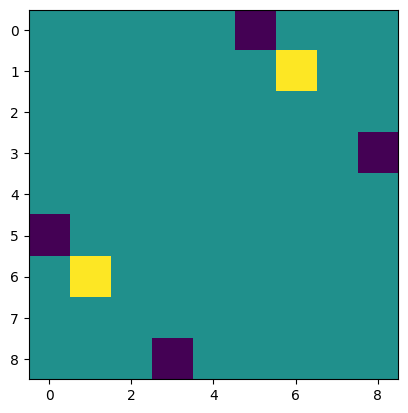

 du calc: 
-u: 
[[-0.8 -0.5 -0.4]
 [-0.9 -0.3 -0.1]
 [-0.6 -0.3 -0.5]]
Q@V: 
[[ 0.   1.   0. ]
 [-0.5  0.  -1. ]
 [ 0.5  0.  -1. ]]
I (L):
[[-0.96402758 -0.96402758  0.        ]
 [-0.96402758  0.          0.96402758]
 [-0.96402758  0.          0.96402758]]
du: 
[[-1.76402758 -0.46402758 -0.4       ]
 [-2.36402758 -0.3        -0.13597242]
 [-1.06402758 -0.3        -0.53597242]]
new V:
[[1.00000000e+00 9.40799943e-05 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00 2.23485012e-05]]
new u:
[[0.78235972 0.49535972 0.396     ]
 [0.87635972 0.297      0.09864028]
 [0.58935972 0.297      0.49464028]]
new u (if loss was *= -1):
[[0.80164028 0.51464028 0.396     ]
 [0.89564028 0.297      0.07935972]
 [0.60864028 0.297      0.47535972]]
Original u:
[[0.8 0.5 0.4]
 [0.9 0.3 0.1]
 [0.6 0.3 0.5]]
new energy:
2.8920801598720596
loss matrix:


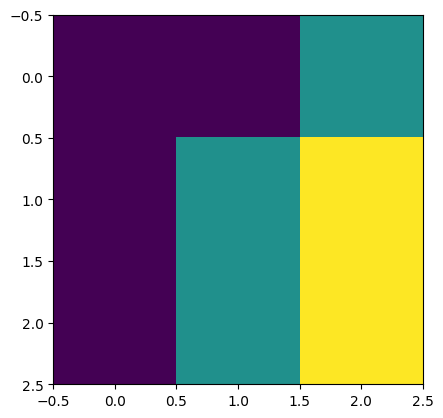

In [109]:
class DummyCleanFunctCallable:
    def __call__(self, V, eq):
        print(eq)
        return eq


eval_clip_to = 1
c_iter = 0

def test_eval_loss_spread(gain=999):
    # Using chars=['a', 'b', 'c'] for simplicity in this test

    c_iter = 0
    chars = ['1', '2', '3']
    max_str_len = 3
    num_syms = len(chars)
    qf = QFactory(max_str_len=3, chars=chars)


    # Setting 2 inhibitory connections and 1 excitatory connection
    # Inhibitory connections (-1)
    qf.qset(0, '1', -1, 1, '3') #0,0 -> 1,2 = -
    qf.qset(1, '1', -1, 2, '3') #1,0 -> 2,2 = -
    # Excitatory connection (1)
    qf.qset(2, '1', 1, 0, '2') #2,0 -> 0,1 = +

    Q = qf.Q
    print("""Q:
    \t(0,0)/(1,2): -
    \t(1,0)/(2,2): -
    \t(2,0)/(0,1): +""")

    # Generate dummy values for V and u

    u = np.array([
        [0.8, 0.5, 0.4],
        [0.9, 0.3, 0.1],
        [0.6, 0.3, 0.5]
    ]).reshape((max_str_len*num_syms,1))

    V = H_SymReg.squasher(u, gain)

    max_indices = np.argmax(V.reshape(max_str_len, num_syms), axis=1)

    # Convert the indices to characters using the chars list
    output_string = ''.join([chars[idx] for idx in max_indices])

    # Instance of EvalLoss_Spread
    evaluator = MathEvaluator_ValueAt(2, 222)
    #loss_fn = EvalLoss_Spread(1, 1000, max_str_len, num_syms)
    loss_fn = EvalLoss(evaluator, max_str_len, num_syms,eval_clip=100)

    # Compute the loss
    c = DummyCleanFunctCallable()
    loss_fn.set_tokenstring_preprocess_function(c)
    loss = loss_fn.forward(output_string, Q, u, V, -100)

    print("--test--")
    print("Original V:")
    print(V.reshape((max_str_len, num_syms)))
    print("Original u:")
    print(u.reshape((max_str_len, num_syms)))
    print("Equation:")
    print(output_string)
    print('old energy:')
    E = (-0.5 * np.dot(V.T, np.dot(Q, V)))[0][0]
    print(E)
    print("\nComputed Loss:")
    print(loss.reshape((max_str_len, num_syms)))
    print("\nQ matrix:")
    qf.plot()


    dt = 0.01


    print(" du calc: ")
    print("-u: ")
    print(-1 * u.reshape((max_str_len, num_syms)))
    print("Q@V: ")
    print((Q@V).reshape((max_str_len, num_syms)))
    print("I (L):")
    print(loss.reshape((max_str_len, num_syms)))


    du = -u + Q @ V + loss

    print("du: ")
    print(du.reshape((max_str_len, num_syms)))

    new_u = u + du * dt
    new_V = H_SymReg.squasher(new_u, gain)

    print("new V:")
    print(new_V.reshape((max_str_len, num_syms)))
    print("new u:")
    print(new_u.reshape((max_str_len, num_syms)))
    print("new u (if loss was *= -1):")
    print((u + (-u + Q @ V - loss) * dt).reshape((max_str_len, num_syms)))
    print("Original u:")
    print(u.reshape((max_str_len, num_syms)))


    # energy calc
    new_E = (-0.5 * np.dot(new_V.T, np.dot(Q, new_V)) - np.dot(new_V.T, loss))[0][0]
    print("new energy:")
    print(new_E)

    print("loss matrix:")
    plt.imshow(loss.reshape((max_str_len, num_syms)))



test_eval_loss_spread()


In [98]:
u = np.array([
        [0.8, 0.5, 0.4],
        [0.9, 0.3, 0.1],
        [0.6, 0.3, 0.5]
    ]).reshape((3*3,1))

V = H_SymReg.squasher(u, 999)

print(V)

V_max = (V > 0.5).astype(float)

V_max_ids = np.where(V, V > 0.5, 1)


print(V_max)

print(V_max_ids)




[[1. ]
 [0.5]
 [0. ]
 [1. ]
 [0. ]
 [0. ]
 [1. ]
 [0. ]
 [0.5]]
[[1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]]
[[1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]]


## Call

0: NNNNNNNNNN
4: NNNNNNNNNN
8: NNNNNNNNNN
12: NNNNNNNNNN
16: NNNNNNNxNN
20: NNNNNNNxNN
24: NNN1N0NxNN
28: NNNNN0NxNN
32: NNNNN0NxNN
36: NNNNN0NxNN
40: NNNNN0NxNN
44: NNNNN0Nx+N
48: NNNNN0NxNN
52: NNNNN0Nx+N
56: NNNNN07xNN
60: NNNNN0NxNN
64: NNNNNNNxNN
68: NNNNNNNxNN
72: NNNNNNNxNN
76: NNNNNNNxNN
80: NNNNNNNxNN
84: NNNNNNNxNN
88: NNNNNNNxNN
92: NNNNNNNxNN
96: NNNNNNNxNN
100: NNNNN0NxNN
104: NNNNN0NxNN
108: NNNNN0NxNN
112: NNNNN0NxNN
116: NNNNN0NxNN
120: NNNNNNNxNN
124: NNNNNNNxNN
128: NNNNNNNxNN
132: NNNNNNNxNN
136: NNNNNNNxNN
140: NNNNNNNxNN
144: NNNNNNNxNN
148: NNNNNNNxNN
152: NNNNNNNxNN
156: NNNNNNNxNN
160: NNNNNNNxNN
164: NNNNN0NxNN
168: NNNNN0NxNN
172: NNNNN0NxNN
176: NNNNNNNxNN
180: NNNNNNNxNN
184: NNNNNNNxNN
188: NNNNNNNxNN
192: NNNNNNNxNN
196: NNNNNNNxNN
200: NNNNNNNxNN
204: NNNNNNNxNN
208: NNNNNNNxNN
212: NNNNNNNxNN
216: NNNNNNNxNN
220: NNNNNNNxNN
224: NNNNNNNxNN
228: NNNNNN7xNN
232: NNNNNN7x+N
236: NNNNNNNxNN
240: NNNNNNNxNN
244: NNNNNNNxNN
248: NNNNNNNxNN
252: NNNNNNNxNN
256:

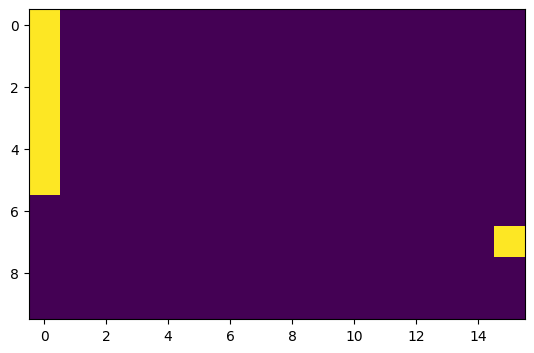

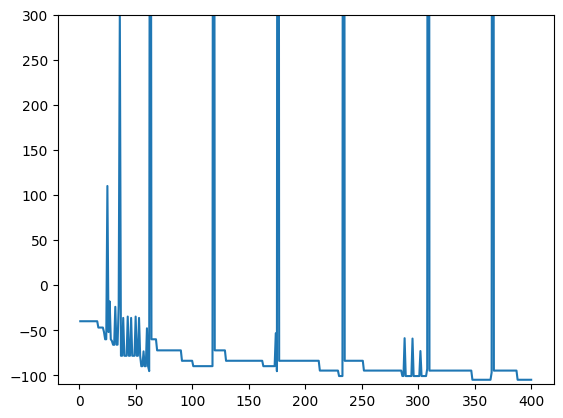

In [112]:
#debug global vars
eval_clip_to = 1
c_iter = 0

chars = ['N','1','2','3','4','5','6','7','8','9','0','+','-','*','/','x']
max_str_len = 10
conf = {
    "c":-20,
    "ofo":-10,
    "ose":-10,
    "nfn":-0.5,
    "NfNd":7,#
    "Nsd":1,
    "nfx":-10,
    "x":1,
    "xm":-2,
    "Nf!N":-10,
    "Ne":-5,
    "Ns":5,#
    "xfx":-10
}
sets = {
    "operators":[c for c in chars if re.match(r'[^0-9Nxy]', c)],
    "numbers":[c for c in chars if re.match(r'[0-9]', c)]
}

qfuncs = math_qfuncs
ifuncts = math_ifuncs

evaluator = MathEvaluator_ValueAt(2, 20)
eval_clip = 400


    # Compute the loss
    #loss_fn.set_tokenstring_preprocess_function(c)
optimizer = None#MaskedLossOptimizer(std_width = 2, decrease_loss_scaler = 2)


my_sr = H_SymReg(chars=chars, max_str_len=max_str_len, conf=conf, sets=sets, Ifuncts = ifuncts, Qfuncts = qfuncs,
                 evaluator = evaluator, optimizer = optimizer, cleanfunct = cleanfunct, eval_clip=eval_clip, min_energy_for_eval=-80, gain=999, dt=0.01)
my_sr.update(n_iters=400, min_dE=0.01, min_E=-300)

y = my_sr.evaluator(my_sr.decode_output())
if y is not None:
    y = y[0]


print(f"generated: {my_sr.decode_output()} = {y} (y_true: {my_sr.evaluator.y}, full: {my_sr.decode_output(clean=False)}) ")
print(f"energy: {my_sr.E_hist[-1]}")
#print(f"loss: {my_sr.get_evalloss()}")
print(f"{len(my_sr.E_hist)} iters")
my_sr.plot_results()
my_sr.plot_Ehist(max_y=300)



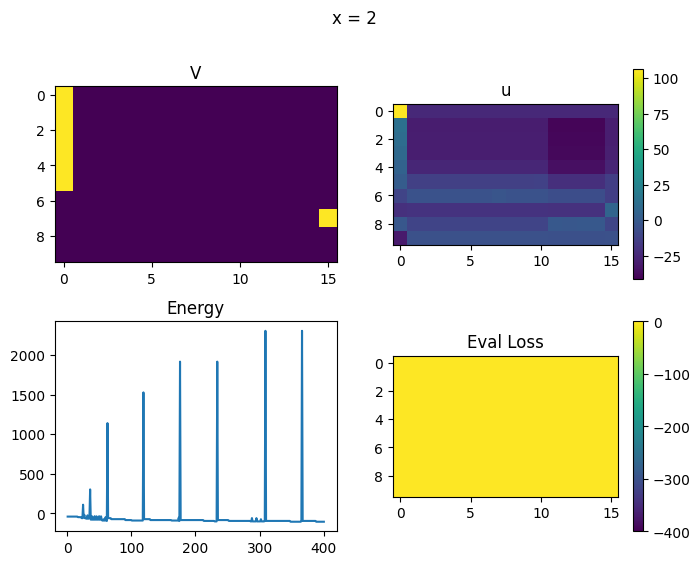

In [113]:
my_sr.plot_histories_as_video()

average inhibition across output positions, of all chars: 
	0, -1.7
	1, -2.16
	2, -2.16
	3, -2.17
	4, -2.17
	5, -2.17
	6, -2.17
	7, -2.17
	8, -2.17
	9, -2.24
average inhibition across characters, of all pos: 
	N, -2.78
	1, -1.98
	2, -1.98
	3, -1.98
	4, -1.98
	5, -1.98
	6, -1.98
	7, -1.98
	8, -1.98
	9, -1.98
	0, -1.98
	+, -2.39
	-, -2.39
	*, -2.39
	/, -2.39
	x, -1.88


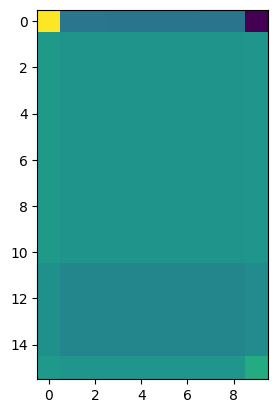

In [101]:
#q landscape
a = my_sr.qfactory.averages()
a_chars = np.mean(a,axis=1)
a_posses = np.mean(a,axis=0)

print("average inhibition across output positions, of all chars: ")
for i, p in zip(range(max_str_len), a_posses):
    print(f'\t{i}, {p:.3}')
print(f"average inhibition across characters, of all pos: ")
for i, p in zip(chars, a_chars):
    print(f'\t{i}, {p:.3}')

plt.imshow(a)
plt.show()

In [102]:
print(a[chars.index('N')])

[ 1.54375  -2.916875 -2.925625 -2.934375 -2.943125 -2.951875 -2.960625
 -2.969375 -2.978125 -5.80375 ]


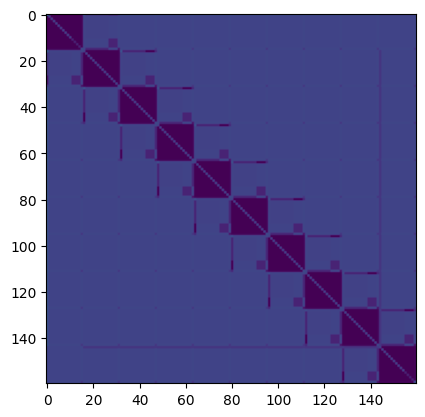

In [103]:
my_sr.qfactory.plot()

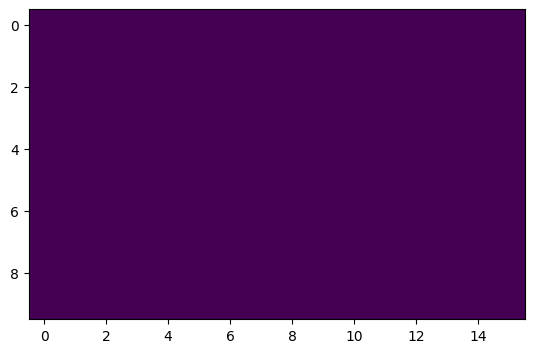

In [104]:
my_sr.ifactory.plot()
#print(my_sr.ifactory.I.reshape((max_str_len, len(chars))))